In [138]:
import numpy as np
import pandas as pd

from sklearn import linear_model
from sklearn.preprocessing import StandardScaler

import time
import math
import os

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

from IPython.display import display

import matplotlib.pyplot as plt
%matplotlib notebook

# functions to calculate WAMP, VWAP, etc.
import functions

np.random.seed(1234)
# set_random_seed(1234)

In [2]:
data_root_dir = "data/kraken/"

In [3]:
updates_file_list = []
snapshots_file_list = []

for (dirpath, dirnames, filenames) in os.walk(data_root_dir):
    updates_file_list.extend([dirpath+'/'+filename for filename in filenames if filename != ".DS_Store" and filename[0] == 'u'])
    snapshots_file_list.extend([dirpath+'/'+filename for filename in filenames if filename != ".DS_Store" and filename[0] == 's'])
    
updates_file_list = sorted(updates_file_list)
snapshots_file_list = sorted(snapshots_file_list)

In [4]:
print(len(snapshots_file_list))
print(len(updates_file_list))
print(snapshots_file_list[0])
print(updates_file_list[0])

250
250
data/kraken/ada_eur/ss_2019-03-15.csv.gz
data/kraken/ada_eur/updates_2019-03-15.csv.gz


# Test

In [ ]:
dataset = np.loadtxt(snapshots_file_list[10], delimiter=',')

In [ ]:
len(dataset)

In [ ]:
# wamp percent - lower difference is considered as NO_MOVE
alpha = 0.002

delay = 100

wamps = [functions.calc_WAMP(ss) for ss in dataset]

y = np.zeros(len(wamps)-delay)

In [ ]:
# Labels: -1 = DOWN  ; 0 = NO_MOVE ;  1 = UP
for i in range(len(wamps)-delay-1):
    mean = np.mean(wamps[i+1:i+delay+1])
    if mean - wamps[i] < -(wamps[i]*alpha):
        y[i] = -1

    elif mean - wamps[i] > wamps[i]*alpha:
        y[i] = 1

    else:
        y[i] = 0

In [ ]:
# Labels: -1 = DOWN ;  1 = UP

for i in range(len(wamps)-delay-1):
    mean = np.mean(wamps[i+1:i+delay+1])
    if mean < wamps[i]:
        y[i] = -1
    else:
        y[i] = 1

In [ ]:
fig, ax = plt.subplots()

markers = ['ro' if label == -1 else 'go' if label == 1 else 'y.' for label in y]

for i, wamp in enumerate(wamps[:-delay]):    
    ax.plot(i, wamps[i], markers[i])
    
plt.show()

In [ ]:
functions.plot_price_movement(dataset[:-50])

# Linear Regression

In [204]:
alpha = 0.002
delay = 100
labels = 2

n_days = 10
n_asset_pairs = 25

n_files = len(snapshots_file_list)
n_ss_per_file = 1440

ss_shape = (200, 3)

In [205]:
dataset = np.zeros([n_files*n_ss_per_file], 
                   dtype=[('snapshot', np.float32, ss_shape), ('rel_prices', np.float32, 200), ('timestamp', np.float32, 1), ('wamp', np.float32, 1),('label', int, 1)])

global_cnt = 0

for i in range(n_asset_pairs):
    asset_pair_cnt = 0
    
    for j in range(n_days):
        data = np.loadtxt(snapshots_file_list[i*n_days+j], delimiter=',')
        
        for j, ss in enumerate(data):
            snapshot = ss[:-1].reshape(-1, 3)
            timestamp = ss[-1]
            wamp = functions.calc_WAMP(ss)

            dataset[global_cnt]["snapshot"] = snapshot
            dataset[global_cnt]["rel_prices"] = [price / wamp for price in snapshot[:,0]]
            dataset[global_cnt]["timestamp"] = timestamp
            dataset[global_cnt]["wamp"] = wamp

            # calculate label for the last snapshot for which enough data is provided with this snapshot
            if asset_pair_cnt >= delay:
                mean = np.mean(dataset["wamp"][global_cnt-delay+1:global_cnt+1])
                act_wamp = dataset["wamp"][global_cnt-delay]
                
                if labels == 3:
                    if mean - act_wamp < -(act_wamp*alpha):
                        dataset[global_cnt-delay]["label"] = -1

                    elif mean - act_wamp > act_wamp*alpha:
                        dataset[global_cnt-delay]["label"] = 1

                    else:
                        dataset[global_cnt-delay]["label"] = 0
                elif labels == 2:
                    if mean < act_wamp:
                        dataset[global_cnt-delay]["label"] = -1
                    else:
                        dataset[global_cnt-delay]["label"] = 1
                else:
                    raise AttributeError()
                    
            asset_pair_cnt += 1
            global_cnt += 1
            
    # set back global_cnt to overwrite not labeled data (last delay number of elements)
    global_cnt = global_cnt-delay

dataset = dataset[:global_cnt]

In [206]:
len(dataset)

355097

<IPython.core.display.Javascript object>


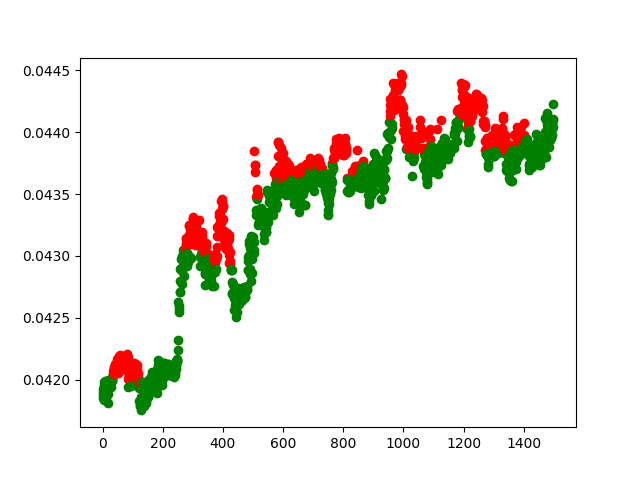

In [207]:
sample = dataset[:1500]

fig, ax = plt.subplots()

markers = ['ro' if label == -1 else 'go' if label == 1 else 'y.' for label in sample["label"]]

for i, wamp in enumerate(sample["wamp"]):    
    ax.plot(i, wamp, markers[i])

plt.show()

In [208]:
cnt = 0
for i,data in enumerate(dataset):
    if data["label"] == -1:
        cnt += 1
print(cnt)

174842


In [209]:
nb_samples = len(dataset)

valid_split = 0.2

In [210]:
#shuffle the dataset
np.random.shuffle(dataset)

In [211]:
# train-valid-test split and one-hot encoding (dataset prep)
#input, select prices only
X_train = dataset['rel_prices'][0:int(nb_samples*(1-valid_split))]
X_valid = dataset['rel_prices'][int(nb_samples*(1-valid_split)):]

#output
Y_train = dataset['label'][0:int(nb_samples*(1-valid_split))]
Y_valid = dataset['label'][int(nb_samples*(1-valid_split)):]

In [212]:
# standard scaling
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)

In [213]:
X_train.shape

(284077, 200)

In [219]:
C = 1e-5

if labels == 2:
    logreg = linear_model.LogisticRegression(C=C,solver='lbfgs')
else:
    logreg = linear_model.LogisticRegression(C=C,solver='sag', multi_class='multinomial')
model = logreg.fit(X_train,Y_train)

In [220]:
logreg.score(X_valid,Y_valid)

0.5830611095466066

In [221]:
predictions = logreg.predict(X_valid)

Confusion matrix, without normalization


<IPython.core.display.Javascript object>


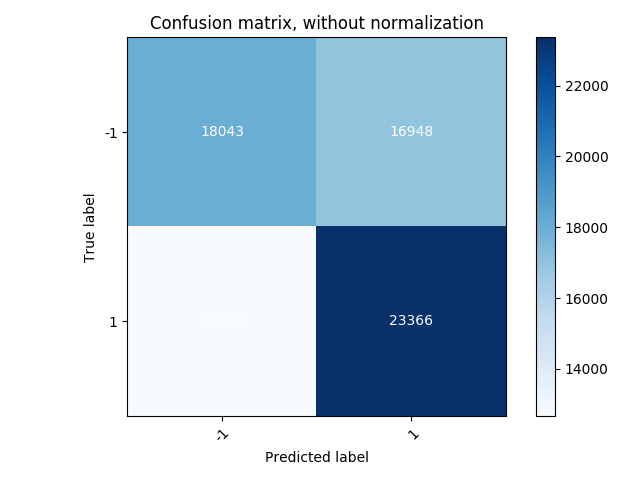

Normalized confusion matrix


<IPython.core.display.Javascript object>


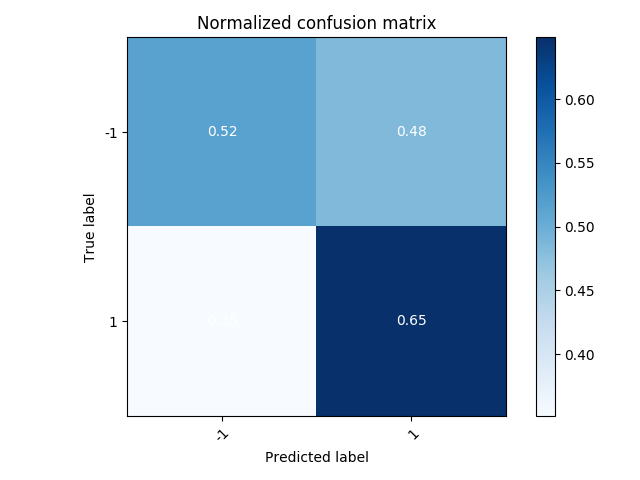

In [222]:
if labels == 2:
    class_names = [-1, 1]
elif labels == 3:
    class_names = [-1, 0, 1]
else:
    class_names = []

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
functions.plot_confusion_matrix(Y_valid, predictions, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
functions.plot_confusion_matrix(Y_valid, predictions, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')